In [1]:
import numpy as np
import pandas as pd
import random as rnd

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

import xgboost as xgb

import sklearn.ensemble as ske
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

seed = 3245678
np.random.seed(seed)
rnd.seed(seed)

In [2]:
### using stratified K-fold to account for imbalanced data
def cross_val_classify(data, target, est, seed):

    classifiers = {'RandomForest': ske.RandomForestClassifier(n_estimators = est, random_state = seed),
                  'GradientBoosting': ske.GradientBoostingClassifier(n_estimators = est, random_state = seed),
                  'AdaBoost': ske.AdaBoostClassifier(n_estimators = est, random_state = seed),
                  'DecisionTree': DecisionTreeClassifier(random_state = seed),}

    sco = []
    
    for classif in classifiers:
        skf    = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
        clf    = classifiers[classif]
        scores = cross_val_score(clf, data, target, cv = skf, n_jobs = -1)           

        print("%s : %0.2f (%0.2f) %%" % (classif, scores.mean() * 100, scores.std() * 100))
        
        sco.append(scores.mean())
        
    return sco

In [3]:
training_data = np.genfromtxt('../input/phishing/phishing.csv', delimiter = ',', dtype = np.int32)

In [4]:
# Identify the inputs (all of the attributes, except for the last one) and the outputs (the last attribute):
inputs  = training_data[:,:-1]
outputs = training_data[:,-1]

In [5]:
# there are 30 features
inputs.shape

(11055, 30)

In [6]:
## there is not null values
np.argwhere(np.isnan(inputs))

array([], shape=(0, 2), dtype=int64)

In [7]:
# dividing the dataset into training and testing:
training_inputs  = inputs[:2000]
training_outputs = outputs[:2000]
testing_inputs   = inputs[2000:]
testing_outputs  = outputs[2000:]

In [8]:
classifier1 = LogisticRegression()
classifier2 = DecisionTreeClassifier()

# Train the classifiers:
classifier1.fit(training_inputs, training_outputs)
classifier2.fit(training_inputs, training_outputs)

predictions1 = classifier1.predict(testing_inputs)
predictions2 = classifier2.predict(testing_inputs)

# print out the accuracy of our phishing detector models:
accuracy1 = 100.0 * accuracy_score(testing_outputs, predictions1)
accuracy2 = 100.0 * accuracy_score(testing_outputs, predictions2)

print ("The accuracy of your Logistic Regression on testing data is: " +str(accuracy1))
print ("The accuracy of your Decision Tree on testing data is: " +str(accuracy2))

The accuracy of your Logistic Regression on testing data is: 84.51684152401988
The accuracy of your Decision Tree on testing data is: 90.56874654886803


To avoid bias that may exist, we use cross-validation.

In [9]:
cross_val_classify(inputs, outputs, 10, seed)

RandomForest : 96.90 (0.32) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 92.90 (0.46) %
DecisionTree : 96.32 (0.40) %


[0.9689733152419719,
 0.9171415649027589,
 0.9289914066033468,
 0.9631840796019902]

The data is already normalized.

### Feature Selection

#### Feature selection using Extra Trees

In [10]:
this_data  = inputs
target     = outputs

FeatSelect = ske.ExtraTreesClassifier(random_state = seed).fit(this_data, target)
Model      = SelectFromModel(FeatSelect, prefit = True)
Data_new   = Model.transform(this_data)

Features   = Data_new.shape[1]
index      = np.argsort(ske.ExtraTreesClassifier().fit(this_data, target).feature_importances_)[::-1][:Features]

In [11]:
Data_new.shape

(11055, 6)

In [12]:
cross_val_classify(Data_new, target, 10, seed)

RandomForest : 93.74 (0.21) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 92.69 (0.25) %
DecisionTree : 93.70 (0.25) %


[0.9374038896426956, 0.9171415649027589, 0.9269109000452284, 0.936951605608322]

#### Feature selection using Random Forest

In [13]:
FeatSelect = ske.RandomForestClassifier(random_state = seed).fit(this_data, target)
Model      = SelectFromModel(FeatSelect, prefit = True)
data_rnf   = Model.transform(this_data)

Features = data_rnf.shape[1]
index    = np.argsort(ske.RandomForestClassifier().fit(this_data, target).feature_importances_)[::-1][:Features]

In [14]:
data_rnf.shape

(11055, 6)

In [15]:
cross_val_classify(data_rnf, target, 10, seed)

RandomForest : 93.74 (0.21) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 92.69 (0.25) %
DecisionTree : 93.70 (0.25) %


[0.9374038896426956, 0.9171415649027589, 0.9269109000452284, 0.936951605608322]

#### Feature selection using recursive feature elimination

In [16]:
estimator = DecisionTreeClassifier(random_state = seed)
selector  = RFECV(estimator, step = 1, cv = 5, n_jobs = -1)
selector.fit(this_data, target)

RFECV(cv=5, estimator=DecisionTreeClassifier(random_state=3245678), n_jobs=-1)

In [17]:
data_rfe = selector.transform(this_data)

In [18]:
data_rfe.shape

(11055, 17)

In [19]:
cross_val_classify(data_rfe, target, 10, seed)

RandomForest : 96.59 (0.36) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 92.90 (0.46) %
DecisionTree : 96.00 (0.48) %


[0.9658977838082314,
 0.9171415649027589,
 0.9289914066033468,
 0.9600180913613748]

#### Data reduction with PCA

In [20]:
pca_scores = []

for i in range(20):
    print(f"------- For {i+1} components")
    pca      = PCA(n_components = i+1, random_state = seed)
    data_pca = pca.fit(this_data).transform(this_data)
    
    pca_scores.append(cross_val_classify(data_pca, target, 10, seed))

------- For 1 components
RandomForest : 80.26 (0.54) %
GradientBoosting : 59.67 (0.24) %
AdaBoost : 61.58 (0.66) %
DecisionTree : 81.85 (0.53) %
------- For 2 components
RandomForest : 88.96 (0.59) %
GradientBoosting : 74.67 (0.68) %
AdaBoost : 73.19 (0.15) %
DecisionTree : 88.52 (0.47) %
------- For 3 components
RandomForest : 91.58 (0.47) %
GradientBoosting : 79.29 (0.55) %
AdaBoost : 78.76 (0.64) %
DecisionTree : 90.27 (0.47) %
------- For 4 components
RandomForest : 93.81 (0.30) %
GradientBoosting : 86.85 (0.64) %
AdaBoost : 84.36 (1.30) %
DecisionTree : 92.69 (0.48) %
------- For 5 components
RandomForest : 94.33 (0.37) %
GradientBoosting : 86.37 (0.51) %
AdaBoost : 86.21 (0.34) %
DecisionTree : 92.99 (0.66) %
------- For 6 components
RandomForest : 94.81 (0.51) %
GradientBoosting : 88.45 (0.81) %
AdaBoost : 87.74 (0.86) %
DecisionTree : 93.80 (0.41) %
------- For 7 components
RandomForest : 95.03 (0.43) %
GradientBoosting : 88.30 (0.85) %
AdaBoost : 88.44 (0.89) %
DecisionTree : 

In [21]:
pca_scores = pd.DataFrame([x[0] for x in pca_scores])
pca_scores.index = range(1, 21)

([<matplotlib.axis.XTick at 0x7f51a1dc5050>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

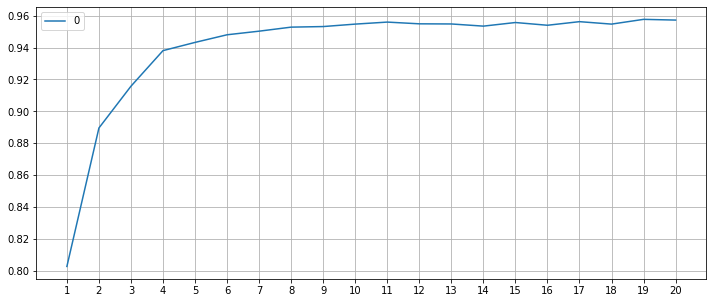

In [22]:
### Random Forest acc values
pca_scores.plot(figsize = (12, 5))

plt.grid(True)
plt.xticks(range(1, 21))

Hence, we define pca with 17 dimensions.

In [23]:
pca      = PCA(n_components = 17, random_state = seed)
data_pca = pca.fit(this_data).transform(this_data)

cross_val_classify(data_pca, target, 10, seed)

RandomForest : 95.63 (0.54) %
GradientBoosting : 88.20 (0.80) %
AdaBoost : 88.17 (1.06) %
DecisionTree : 94.11 (0.75) %


[0.9563093622795116,
 0.8819538670284939,
 0.8816824966078697,
 0.9411126187245591]

#### Feature Selection using ANOVA (statistical test)

Chi2 does not work here since it has negative values.

In [24]:
stat_scores = []

for i in range(20):
    print(f"------- For {i+1} components")
    
    test      = SelectKBest(f_classif, k = i+1)
    fit       = test.fit(this_data, target)
    data_stat = fit.transform(this_data)
    
    stat_scores.append(cross_val_classify(data_stat, target, 10, seed))

------- For 1 components
RandomForest : 88.89 (0.49) %
GradientBoosting : 88.89 (0.49) %
AdaBoost : 88.89 (0.49) %
DecisionTree : 88.89 (0.49) %
------- For 2 components
RandomForest : 91.26 (0.25) %
GradientBoosting : 91.15 (0.36) %
AdaBoost : 91.11 (0.34) %
DecisionTree : 91.26 (0.25) %
------- For 3 components
RandomForest : 91.71 (0.29) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 91.73 (0.30) %
DecisionTree : 91.70 (0.29) %
------- For 4 components
RandomForest : 92.13 (0.30) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 91.66 (0.26) %
DecisionTree : 92.12 (0.29) %
------- For 5 components
RandomForest : 93.12 (0.25) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 90.95 (0.48) %
DecisionTree : 93.12 (0.25) %
------- For 6 components
RandomForest : 93.29 (0.21) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 92.27 (0.12) %
DecisionTree : 93.32 (0.30) %
------- For 7 components
RandomForest : 93.83 (0.36) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 92.75 (0.22) %
DecisionTree : 

([<matplotlib.axis.XTick at 0x7f51a1c706d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

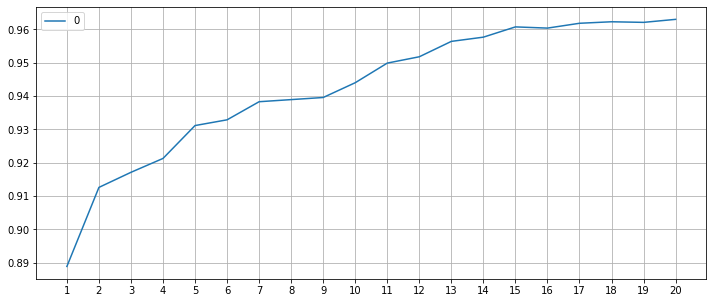

In [25]:
stat_scores = pd.DataFrame([x[0] for x in stat_scores])
stat_scores.index = range(1, 21)

### Random Forest acc values
stat_scores.plot(figsize = (12, 5))

plt.grid(True)
plt.xticks(range(1, 21))

We set 15 features since the difference in acc when adding more features is small.

In [26]:
test      = SelectKBest(f_classif, k = 15)
fit       = test.fit(this_data, target)
data_stat = fit.transform(this_data)

cross_val_classify(data_stat, target, 10, seed)

RandomForest : 96.07 (0.39) %
GradientBoosting : 91.71 (0.28) %
AdaBoost : 92.90 (0.46) %
DecisionTree : 95.52 (0.49) %


[0.9607417458163727,
 0.9171415649027589,
 0.9289914066033468,
 0.9552238805970148]

#### Outlier detection

In [27]:
model  = ske.IsolationForest(n_estimators = 50, max_samples='auto', contamination=float(0.1), max_features=1.0, random_state = seed)
y_pred = model.fit_predict(data_rfe)

df_out     = pd.DataFrame(data_rfe[np.where(y_pred == 1, True, False)])
target_out = target[np.where(y_pred == 1)]

cross_val_classify(df_out, target_out, 10, seed)

RandomForest : 96.52 (0.35) %
GradientBoosting : 91.48 (0.31) %
AdaBoost : 92.48 (0.37) %
DecisionTree : 95.70 (0.47) %


[0.9652228462574308, 0.9147653804467284, 0.924816591757177, 0.9569807812314461]

In [28]:
model  = LocalOutlierFactor(n_neighbors = 5)
y_pred = model.fit_predict(data_rfe)

df_out     = pd.DataFrame(data_rfe[np.where(y_pred == 1, True, False)])
target_out = target[np.where(y_pred == 1)]

cross_val_classify(df_out, target_out, 10, seed)

RandomForest : 96.82 (0.35) %
GradientBoosting : 91.91 (0.48) %
AdaBoost : 92.98 (0.54) %
DecisionTree : 95.98 (0.29) %


[0.9682117107363121,
 0.9190833078413378,
 0.9297863369778293,
 0.9597565600356545]

### Parameter Tuning

In [29]:
param_grid = { 
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion'   : ['gini', 'entropy']
}

skf    = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
rfc    = ske.RandomForestClassifier(random_state = seed)
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = skf, verbose = 3, n_jobs = -1)
CV_rfc.fit(df_out, target_out)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=3245678, shuffle=True),
             estimator=RandomForestClassifier(random_state=3245678), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [10, 50, 100, 200, 500]},
             verbose=3)

In [30]:
CV_rfc.best_params_

{'criterion': 'entropy', 'n_estimators': 200}

In [31]:
scoring = ['accuracy', 'precision', 'recall']

best_clf = CV_rfc.best_estimator_
best_scores = cross_validate(best_clf, df_out, target_out, cv = skf, n_jobs = -1, scoring = scoring)

print("Random Forest with Grid Search")
print("Acc (std) : %0.2f (%0.2f) %%" % (best_scores['test_accuracy'].mean() * 100, best_scores['test_accuracy'].std() * 100))
print("Pre (std) : %0.2f (%0.2f) %%" % (best_scores['test_precision'].mean() * 100, best_scores['test_precision'].std() * 100))
print("Rec (std) : %0.2f (%0.2f) %%" % (best_scores['test_recall'].mean() * 100, best_scores['test_recall'].std() * 100))

Random Forest with Grid Search
Acc (std) : 97.11 (0.20) %
Pre (std) : 96.72 (0.20) %
Rec (std) : 98.16 (0.47) %


#### Final Features

In [32]:
skf        = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
clf        = ske.RandomForestClassifier(n_estimators = 10, random_state = seed)
cut_scores = cross_validate(best_clf, df_out, target_out, cv = skf, n_jobs = -1, scoring = scoring)

print("Random Forest with %d features \n" % df_out.shape[1])
print("Acc (std) : %0.2f (%0.2f) %%" % (cut_scores['test_accuracy'].mean() * 100, cut_scores['test_accuracy'].std() * 100))
print("Pre (std) : %0.2f (%0.2f) %%" % (cut_scores['test_precision'].mean() * 100, cut_scores['test_precision'].std() * 100))
print("Rec (std) : %0.2f (%0.2f) %%" % (cut_scores['test_recall'].mean() * 100, cut_scores['test_recall'].std() * 100))

Random Forest with 17 features 

Acc (std) : 97.11 (0.20) %
Pre (std) : 96.72 (0.20) %
Rec (std) : 98.16 (0.47) %


In [33]:
result = cross_val_predict(clf, df_out, target_out, cv = skf, n_jobs = -1)
CM     = confusion_matrix(target_out, result)

print("False positive rate : %f %%" % ((CM[0][1] / float(sum(CM[0])))*100))
print('False negative rate : %f %%' % ( (CM[1][0] / float(sum(CM[1]))*100)))

False positive rate : 4.128218 %
False negative rate : 2.430622 %


In [34]:
skf        = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
clf        = ske.RandomForestClassifier(n_estimators = 10, random_state = seed)
all_scores = cross_validate(best_clf, inputs, target, cv = skf, n_jobs = -1, scoring = scoring)

print("Random Forest with all features")
print("Acc (std) : %0.2f (%0.2f) %%" % (all_scores['test_accuracy'].mean() * 100, all_scores['test_accuracy'].std() * 100))
print("Pre (std) : %0.2f (%0.2f) %%" % (all_scores['test_precision'].mean() * 100, all_scores['test_precision'].std() * 100))
print("Rec (std) : %0.2f (%0.2f) %%" % (all_scores['test_recall'].mean() * 100, all_scores['test_recall'].std() * 100))

Random Forest with all features
Acc (std) : 97.21 (0.17) %
Pre (std) : 96.85 (0.34) %
Rec (std) : 98.20 (0.16) %


In [35]:
result = cross_val_predict(best_clf, inputs, target, cv = skf, n_jobs = -1)
CM     = confusion_matrix(target, result)

print("False positive rate : %f %%" % ((CM[0][1] / float(sum(CM[0])))*100))
print('False negative rate : %f %%' % ( (CM[1][0] / float(sum(CM[1]))*100)))

False positive rate : 4.022050 %
False negative rate : 1.802826 %


In [36]:
n0 = inputs.shape[1] - data_rfe.shape[1]
n1 = all_scores['test_accuracy'].mean() * 100 - cut_scores['test_accuracy'].mean() * 100
n2 = all_scores['test_precision'].mean() * 100 - cut_scores['test_precision'].mean() * 100
n3 = all_scores['test_recall'].mean() * 100 - cut_scores['test_recall'].mean() * 100

print(f"Using less {n0} features, with difference of {n1:.2f} % in acc, {n2:.2f} % in pre, and {n3:.2f} % in rec")

Using less 13 features, with difference of 0.10 % in acc, 0.13 % in pre, and 0.03 % in rec


In [37]:
df_acc = pd.DataFrame(all_scores['test_accuracy'])
df_acc = pd.concat([df_acc, pd.Series(cut_scores['test_accuracy'])])
df_acc['metrics'] = ['all'] * 5 + ['selection'] * 5

df_pre = pd.DataFrame(all_scores['test_precision'])
df_pre = pd.concat([df_pre, pd.Series(cut_scores['test_precision'])])
df_pre['metrics'] = ['all'] * 5 + ['selection'] * 5

df_rec = pd.DataFrame(all_scores['test_recall'])
df_rec = pd.concat([df_rec, pd.Series(cut_scores['test_recall'])])
df_rec['metrics'] = ['all'] * 5 + ['selection'] * 5

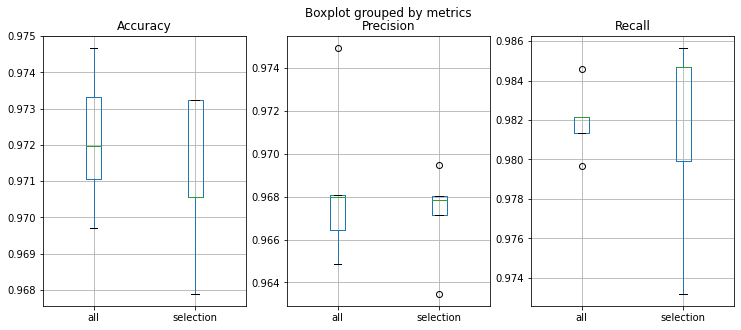

In [38]:
fig, axes = plt.subplots(ncols = 3, figsize = (12, 5))

df_acc.boxplot(by = 'metrics', ax = axes.flatten()[0])
df_pre.boxplot(by = 'metrics', ax = axes.flatten()[1])
df_rec.boxplot(by = 'metrics', ax = axes.flatten()[2])

axes.flatten()[0].set_title('Accuracy')
axes.flatten()[1].set_title('Precision')
axes.flatten()[2].set_title('Recall')

axes.flatten()[0].set_xlabel('')
axes.flatten()[1].set_xlabel('')
axes.flatten()[2].set_xlabel('')

plt.show()